In [45]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Lecture 16 – Hypothesis Testing, Continued

## DSC 10, Spring 2022

### Announcements

- The Midterm Project is due **tomorrow at 11:59pm**.
    - Slip days can be used if needed.
    - If working with a partner, only **one** person should submit, and "Add Group Member".
- Lab 5 is due on **Tues at 11:59pm**.

### Agenda

- Decisions and uncertainty.
- Example: Midterm scores.
    - p-values.
- Example: Jury Panels.
    - Total variation distance.

## Decisions and uncertainty

### Incomplete information

- We try to choose between two views of the world, based on data in a sample.
- It's not always clear whether the data are consistent with one view or the other.
- Random samples can turn out quite extreme. It is unlikely, but possible.

### Testing hypotheses
- A test chooses between two views of how data were generated.
- The views are called **hypotheses**.
- The test picks the hypothesis that is better supported by the observed data.
    - We will formalize this notion now.

### Null and alternative hypotheses
- This method only works if we can simulate data under one of the hypotheses.
- **Null hypothesis**: A well-defined probability model about how the data were generated.
    - We can simulate data under the assumptions of this model – “under the null hypothesis”.
- **Alternative hypothesis**: A different view about the origin of the data.

### Test statistics, revisited
- Recall, we compute the test statistic on each of our samples in our simulation.
- Its goal is to give us information that will help us in determining which hypothesis to side with.
- The test statistic evaluated on our observed data is called the **observed statistic**.

Questions before choosing the statistic:
- What values of the statistic will make us lean towards the null hypothesis?
- What values will make us lean towards the alternative?
    - The answer should be just “high” or just "low". 
    - Try to avoid “both high and low”: this is why, for example, we used the statistic $| \text{proportion purple} - 0.75|$ when our alternative hypothesis was "the proportion of purple plants is not 0.75."

### Empirical distribution of the test statistic
- When performing a hypothesis test, we **simulate** the test statistic **under the null hypothesis** and draw a histogram of the simulated values.
- This shows us the **empirical distribution of the test statistic under the null hypothesis**.
    - It shows all of the likely values of the test statistic.
    - It also shows how likely they are, under the assumption that the null hypothesis is true.
    - The probabilities are approximate, because we can’t generate all possible random samples.
- We side with the null only if the observed statistic is **consistent** with the empirical distribution of the test statistic.
- **Question:** is there a formal definition for what we mean by "consistent"?

## Example: Midterm scores

### The problem

- Consider a large Biology course divided into 12 discussion sections. 
- Each student is in exactly one discussion section.
- TAs lead the sections.
- After the midterm exam, students in Section 3 notice that the average score in their section is lower than in others.

### The TA's defense

- **The TA's position (Null Hypothesis)**: It's chance. If students were divided into sections randomly, we'd probably see at least one section with a score this low.
- **Alternative Hypothesis**: No, the average score is too low. Randomness is not the only reason for the low scores.
- Let's perform a hypothesis test!

In [16]:
scores = bpd.read_csv('data/scores_by_section.csv')
scores

,Section,Midterm
0,1,22
1,2,12
2,2,23
...,...,...
356,2,17
357,12,16
358,10,14


In [17]:
scores.groupby('Section').count()

,Midterm
Section,
1,32
2,32
3,27
...,...
10,34
11,26
12,30


In [18]:
# Calculate the average midterm score per section
scores.groupby('Section').mean()

,Midterm
Section,
1,15.59
2,15.12
3,13.67
...,...
10,15.24
11,15.81
12,15.73


### What are the observed characteristics of section 3?

In [19]:
section_size = scores.groupby('Section').count().get('Midterm').loc[3]
observed_avg = scores.groupby('Section').mean().get('Midterm').loc[3]
print(f'Section 3 had {section_size} students and an average midterm score of {observed_avg}.')

Section 3 had 27 students and an average midterm score of 13.666666666666666.


### You Try: Simulating under the null hypothesis

- Null: There is no difference between the exam scores in different sections.
- Alternative: Section 3's exam scores are lower than the other sections' scores.
- To simulate: sample 27 students uniformly at random without replacement from the class.
- Test statistic: You decide!
- Plot the distribution of the test statistic, plot the observed statistic as a vertical line, and make a decision.

### Simulating Scores

In [20]:
scores.sample(int(section_size), replace=False).get('Midterm').mean()

17.333333333333332

In [42]:
sample_means = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample = scores.sample(int(section_size), replace=False)
    mean = sample.get('Midterm').mean()
    sample_means = np.append(sample_means, mean)
    
sample_means

array([14.81, 15.26, 13.52, ..., 15.44, 14.78, 16.7 ])

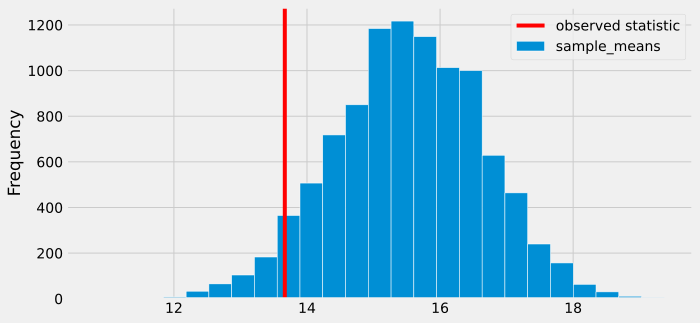

In [43]:
bpd.DataFrame().assign(sample_means=sample_means).plot(kind='hist', bins=25, ec='w', figsize=(10, 5))
plt.axvline(observed_avg, color='red', label='observed statistic')
plt.legend();

### What's the verdict? 🤔
- This is not as obvious as in previous examples, where it was clear whether the observed statistic was consistent with the empirical distribution of the test statistic.
- We need a precise way of capturing the uncertainty of the conclusion.

## Statistical significance

**Question:** What is the probability that under the null hypothesis, a result *at least* as extreme as our observation occurs?

- In this example, what is the probability that under the null hypothesis, a section of 27 students has an average exam score of 13.66 or lower?
- This is the **area in the tail of the empirical distribution**.
- This quantity is also called a **p-value**.

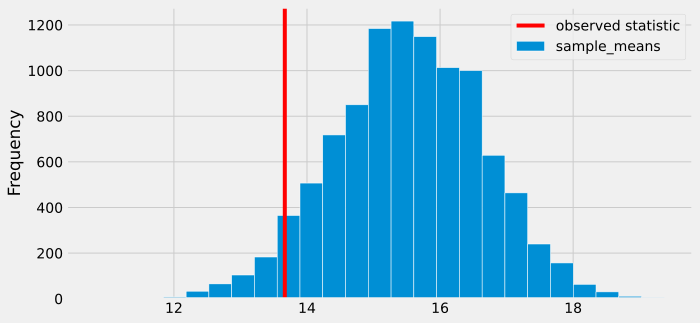

In [44]:
bpd.DataFrame().assign(sample_means=sample_means).plot(kind='hist', bins=25, ec='w', figsize=(10, 5))
plt.axvline(observed_avg, color='red', label='observed statistic')
plt.legend();

In [23]:
observed_avg

13.666666666666666

In [24]:
np.count_nonzero(averages <= observed_avg) / repetitions

0.058

### Definition of the p-value

- The p-value is **the probability, under the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative**.
- Its formal name is the _observed significance level_.
- In the previous visualization, it is the area to the left of the red line (i.e. the area in the left tail, starting at the observed statistic).

### Conventions about inconsistency

- If the p-value is sufficiently large, we say the data is **consistent** with the null hypothesis and so we "**fail to reject the null hypothesis**".
    - We never say that we "accept" the null hypothesis!
    - Why not? We found that the null hypothesis is plausible, but there are many other possible explanations for our data.
- If the p-value is below some cutoff, we say it is **inconsistent** with the null hypothesis, and we **"reject the null hypothesis"**.
    - p-values correspond to the "tail areas" of a histogram, starting at the observed statistic.
    - If a p-value is less than 0.05, the result is said to be "statistically significant".
    - If a p-value is less than 0.01, the result is said to be "highly statistically significant".
    - These conventions are historical and completely arbitrary! (And controversial.)

### What does the p-value mean?

The cutoff for the p-value is an error probability. If:

- your cutoff is 0.05, and
- the null hypothesis happens to be true

then there is about a 0.05 chance that your test will (incorrectly) reject the null hypothesis.

- In other words, if the same TA teaches 20 discussion sections for the same course, they should expect to see students with a "statistically significantly low" average in one of those sections.

## Comparing distributions

### Jury Selection in Alameda County

<br>

<center><img src='data/aclu.png' width=500></center>

### Jury panels

$$\text{eligible population} \rightarrow \text{list of eligible jurors} \rightarrow \text{jury panel} \rightarrow \text{actual jury}$$

Section 197 of California's Code of Civil Procedure says, 
> "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

### ACLU study:
- The ACLU (American Civil Liberties Union) of Northern California studied the ethnic composition of jury panels in 11 felony trials in Alameda County between 2009 and 2010.
    - [Here's a link](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) to the study.
- 1453 people reported for jury duty in total (we will call them "panelists").
- The following DataFrame shows the distribution in ethnicities for both the eligible population and for the panelists who were studied.

In [26]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


What do you notice? 🤔

### Are the differences in representation meaningful?
- Model: Panelists were selected at random from the eligible population.
    - Alternative viewpoint: no, they weren't.
- Observation: 1453 panelists and the distribution of their ethnicities.
- Test statistic: ???
    - How do we deal with multiple categories?

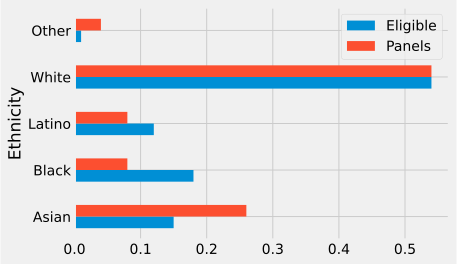

In [27]:
jury.plot(kind='barh', x='Ethnicity');

### The distance between two distributions
- Panelists are categorized into one of 5 ethnicities.
- The distribution of ethnicities is **categorical**.
- To see whether the the distribution of ethnicities for the panelists is similar to that of the eligible population, we have to measure the distance between two categorical distributions.

### The distance between two distributions
- Let's start by considering the difference in proportions for each category.

In [28]:
with_diffs = jury.assign(Difference=(jury.get('Panels') - jury.get('Eligible')))
with_diffs

,Ethnicity,Eligible,Panels,Difference
0,Asian,0.15,0.26,0.11
1,Black,0.18,0.08,-0.10
2,Latino,0.12,0.08,-0.04
3,White,0.54,0.54,0.00
4,Other,0.01,0.04,0.03


- Note that if we sum these differences, the result is 0.
- So that the positive and negative differences don't "cancel", we can take the absolute value of these differences.

In [29]:
with_abs_diffs = with_diffs.assign(AbsoluteDifference=np.abs(with_diffs.get('Difference')))
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


### Statistic: Total Variation Distance
- The **Total Variation Distance (TVD)** of two categorical distributions is **the sum of the absolute differences of their proportions, all divided by 2**.
    - We divide by 2 so that, for example, the distribution [0.51, 0.49] is 0.01 away from [0.50, 0.50].
    - This way, TVD quantifies the **total overrepresentation** across all categories.
    - It would also be valid not to divide by 2. We just wouldn't call that statistic TVD anymore.

In [30]:
with_abs_diffs

,Ethnicity,Eligible,Panels,Difference,AbsoluteDifference
0,Asian,0.15,0.26,0.11,0.11
1,Black,0.18,0.08,-0.10,0.10
2,Latino,0.12,0.08,-0.04,0.04
3,White,0.54,0.54,0.00,0.00
4,Other,0.01,0.04,0.03,0.03


In [31]:
with_abs_diffs.get('AbsoluteDifference').sum() / 2

0.14

### You Try: 10 and 40A

What is the TVD between the distributions of class standing in DSC 10 and DSC 40A?

| **Class Standing** | **DSC 10** | **DSC 40A** |
| --- | --- | --- |
| Freshman | 0.45 | 0.15 |
| Sophomore | 0.35 | 0.35 |
| Junior | 0.15 | 0.35 |
| Senior+ | 0.05 | 0.15 |


### Statistic: Total Variation Distance

In [32]:
def total_variation_distance(dist1, dist2):
    '''Computes the TVD between two categorical distributions, 
       assuming the categories appear in the same order.'''
    return np.abs((dist1 - dist2)).sum() / 2

In [33]:
# Calculate the TVD between the distribution of ethnicities in the eligible population
# and the distribution of ethnicities in the observed panelists

total_variation_distance(jury.get('Eligible'), jury.get('Panels'))

0.14

- The closer the TVD is to 0, the closer the two distributions are to one another.
- But is 0.14 a very small value? A typical value? A very large value?

### Simulate drawing jury panels
- Model: Panels are drawn at from the eligible population.
- Statistic: TVD between the random panel's ethnicity distribution and the eligible population's ethnicity distribution.
- Repeat many times to generate many TVDs, and see where the TVD of the observed panelists lies.

_Note: `np.random.multinomial` creates samples drawn with replacement, even though real jury panels would be drawn without replacement. However, when the sample size is small relative to the population, the resulting distributions will be roughly the same whether we sample with or without replacement._

### You Try: Jury Panels using TVD

1. Draw a random jury panel of 1453 people from the population. Calculate the TVD between the sample and population.
1. Repeat 10,000 times, store results in an array called `tvds`.
1. Plot the `tvds` in a histogram, and plot the observed TVD (0.14) as a vertical line.
1. Calculate the p-value for this hypothesis test, and draw a conclusion.

### The simulation

In [34]:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453 
sample_distribution

array([0.16, 0.18, 0.13, 0.53, 0.  ])

In [35]:
panels_and_sample = jury.assign(RandomSample=sample_distribution) 
panels_and_sample

,Ethnicity,Eligible,Panels,RandomSample
0,Asian,0.15,0.26,1.60e-01
1,Black,0.18,0.08,1.84e-01
2,Latino,0.12,0.08,1.26e-01
3,White,0.54,0.54,5.26e-01
4,Other,0.01,0.04,4.82e-03


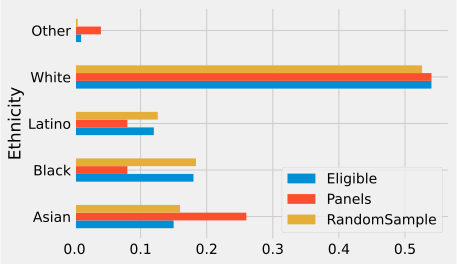

In [36]:
panels_and_sample.plot(kind='barh', x='Ethnicity');

In [37]:
total_variation_distance(panels_and_sample.get('RandomSample'), eligible)

0.019373709566414335

### Repeating the experiment

In [38]:
tvds = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

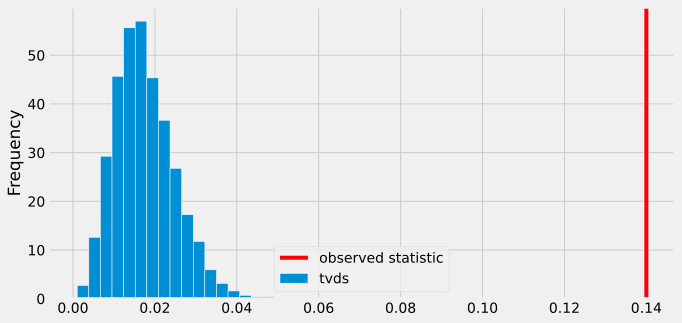

In [39]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(tvds=tvds).plot(kind='hist', density=True, bins=20, ec='w', figsize=(10, 5))
plt.axvline(observed_tvd, color='red', label='observed statistic')
plt.legend();

### Calculating the p-value

In [40]:
np.count_nonzero(tvds >= observed_tvd) / repetitions

0.0

When the p-value is tiny, Python rounds to 0.

### Are the jury panels representative?
- Likely not! The distributions of ethnicities in our random samples are not like the distribution of ethnicities in our observed panelists.
- This doesn't say *why* the distributions are different!
    - Juries are drawn from voter registration lists and DMV records. Certain populations are less likely to be registered to vote or have a driver's license due to historical biases.
    - The county rarely enacts penalties for those who don't appear for jury duty; certain populations are less likely to be able to miss work to appear for jury duty.
    - [See the report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) for more reasons.

## Recipe for Hypothesis Test

1. State: null and alternative hypotheses.
1. Pick test statistic: use alternative hypothesis to decide what test statistic to use.
1. Simulate: draw samples under the null hypothesis, calculate the test statistic on each one.
1. Visualize: plot the simulated values and observed test statistic.
1. Find p-value: proportion of simulations that have values at least as extreme as the one observed.

## Why does it matter?

- Lower p-value = more "weird".
- Hypothesis testing is used all the time to make decisions in science and business.
- Hypothesis testing quantifies how "weird" a result is.
    - Instead of saying, "I think that's unusual"...
    - ...people say, "This has a p-value of 0.001".
- Also shows general pattern in data science:
    - Simulate, then use simulations to see how likely something is to happen.
- So far, we used knowledge about population (e.g. % of ethnicities).
    - Next time: What do we do if we don't know the population?